# 2 ML Features Selection & Model Training

Runs:
- Study Load & Inspections [Jump To](#run-1-study-load--inspections)
- Feature Selection & Data Prep [Jump To](#run-2-feature-selection--data-prep)
- Model Training [Jump To](#run-3-model-training)
- Model Training with Combined Grid Search [Jump To](#run-4-models-training-with-combined-grid-search)


In [1]:
# # Save Current Session
# import dill

# dill.dump_session('temp_save_session.pkl')

In [2]:
# # Load a previous session
# import dill

# dill.load_session('temp_save_session.pkl')

# Imports & Functions

## Imports

In [3]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from ml_utilities import ml_model_pipeline_details, grid_search_results, classification_metrics 
from ml_utilities import feature_importance, get_shap_importance, get_prediction_probabilities
import shap

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



## Results & Features Inspection

In [4]:
# Plots for subject info
#

def subject_info_plot(subjects_df):

    # PD & Gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - PD & Gender', fontsize=18)

    counts = subjects_df['pd'].value_counts()
    axes[0].set_title('PD')
    axes[0].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    counts = subjects_df['gender'].value_counts()
    axes[1].set_title('Gender')
    axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[1].set_xticks(range(len(counts.index)))
    axes[1].set_xticklabels(['Male', 'Female'])
    for i, (label, count) in enumerate(counts.items()):
        axes[1].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Age Distribution & Box
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - Age Distribution', fontsize=18)

    axes[0].hist(subjects_df['age'], bins=15, color='skyblue', edgecolor='black')

    axes[1].set_xticks([0])
    box = axes[1].boxplot(subjects_df['age'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [5]:
# Plots for EEG Preprocessing Results
#

def eeg_preprocess_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG Preprocessing Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['EEG_preprocessing_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # # Channels count
    # counts = results_df['channel_count'].value_counts()
    # axes[1].set_title('Channels Count')
    # axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue'], edgecolor='black')

    # ICA Rejection Level
    axes[1].set_title('ICA - ICs Rejection Level')
    box = axes[1].boxplot(results_df['ICA_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Epoch Rejection Level
    axes[2].set_title('Epoch Rejection Level')
    box = axes[2].boxplot(results_df['epoch_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')
    # axes[2].set_xlabel('Epoch Rejection Level')
    # axes[2].set_ylabel('Number of Subjects')
    # axes[2].hist(results_df['epoch_rejection_level'], bins=10, color='skyblue', edgecolor='black')
    # nonzero_epoch_rejection = results_df['epoch_rejection_level'][results_df['epoch_rejection_level'] > 0]
    # axes[2].hist(nonzero_epoch_rejection, bins=15, color='salmon', edgecolor='black', alpha=0.7)
    # for bar in axes[2].patches:
    #     bar.set_width(bar.get_width() * 0.8)

    plt.tight_layout()
    plt.show()


In [6]:
# Plots for EEG SpecParam Results
#

def eeg_specparam_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG SpecParam Fit Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['chn_SPM_fit_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # Error Mean
    axes[1].set_title('Error Mean')
    box = axes[1].boxplot(results_df['chn_error_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # R-Squared Mean
    axes[2].set_title('R2 Mean')
    box = axes[2].boxplot(results_df['chn_r2_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()

    # Number of flagged channels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))
    # fig.suptitle('EEG SpecParam Fit Metrics - Flagged Channels', fontsize=18)
    flagged_counts = results_df['chn_flagged_channels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes.set_title('Flagged Channels Count')
    box = axes.boxplot(flagged_counts, patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='salmon')

    plt.tight_layout()
    plt.show()

In [7]:
# Plots for Aperiodic Features Spread
#

def aperiodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Aperiodic Features - {level}', fontsize=18)

    # Offset
    axes[0].set_title('Offset')
    box = axes[0].boxplot(results_df['offset'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Exponent
    axes[1].set_title('Exponent')
    box = axes[1].boxplot(results_df['exponent'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [8]:
# Plots for Periodic Features Spread
#

def periodic_features_plot(results_df, level):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle(f'Periodic Features - {level}', fontsize=18)

    # CF
    axes[0].set_title('CF_0')
    box = axes[0].boxplot(results_df['cf_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # PW
    axes[1].set_title('PW_0')
    box = axes[1].boxplot(results_df['pw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # BW
    axes[2].set_title('BW_0')
    box = axes[2].boxplot(results_df['bw_0'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [9]:
# Plots for Aperiodic Peaks Count 
#

def periodic_peaks_plot(results_df):

    regions_df = results_df[results_df['channel'].isnull()].copy()
    cf_cols = [col for col in regions_df.columns if col.startswith('cf_')]
    regions_df['num_periodic_cf'] = regions_df[cf_cols].notnull().sum(axis=1)
    
    channels_df = results_df[results_df['region'].isnull()].copy()
    cf_cols = [col for col in channels_df.columns if col.startswith('cf_')]
    channels_df['num_periodic_cf'] = channels_df[cf_cols].notnull().sum(axis=1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Periodic Peaks Count', fontsize=18)

    # Region
    axes[0].set_title('Regions')
    box = axes[0].boxplot(regions_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Channel
    axes[1].set_title('Channels')
    box = axes[1].boxplot(channels_df['num_periodic_cf'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


# Run: 1. Study Load & Inspections

In [10]:
# Study and Processing Run Details

#---- Parameters --------------------------------
# Study & Processing Run Details
study_name = 'IOWA_Rest'
eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'

run_description = 'regions_aperiodic_subject'
# test_mode = False

# Extraction Parameters
extraction_params = {'features_detail_level': 'region',    # region or channel, default channels
                     'subject_meta_include': True,
                     'aperiodic_include': True,
                     'periodic_include': False
                    }
model_training_params = {'EEG_features_source_run': eeg_features_run}
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')

# Setup the extraction run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'2_Feature_Selection_Training_Run_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['ml_training_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'study_name': study_name,
    'run_name': run_name,
    'extraction_params': extraction_params,
    'model_training_params': model_training_params
    })
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# # Set progress messages, testing
# if test_mode:
#     VERBOSE = True
#     TEST_SUBJECTS = [0,5,101]
#     # TEST_CHANNELS = ['F5', 'C3', 'P3', 'F6', 'C6', 'P6']
# else:
#     VERBOSE = False
#     TEST_SUBJECTS = []
#     # TEST_CHANNELS = []

EEG Processing Parameters
- Study: IOWA_Rest ds004584-1.0.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250724_full_ica
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250801_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
- Features Selection Run: 2_Feature_Selection_Training_Run_20250808_regions_aperiodic_subject
-   Feature Selection Params: {'features_detail_level': 'region', 'subject_meta_include': True, 'aperiodic_include': True, 'periodic_include': False}
-   Model Training Params

,subject_id,EEG_preprocessing_quality_warning,channel_count,ICA_components_count,ICA_rejection_level,epochs_count,epoch_rejection_level,reg_SPM_fit_quality_warning,reg_spectra_count,reg_null_fits,...,reg_peaks_count_max,reg_peaks_count_mean,chn_SPM_fit_quality_warning,chn_spectra_count,chn_null_fits,chn_error_mean,chn_r2_mean,chn_flagged_channels,chn_peaks_count_max,chn_peaks_count_mean
0,sub-001,False,63,62,0.467742,281,0.0,False,3,0,...,2,2.0,True,63,0,0.042768,0.920499,[33],4,2.190476
1,sub-002,False,63,62,0.064516,326,0.0,False,3,0,...,3,2.333333,True,63,0,0.057373,0.976498,"[10, 20, 52]",3,1.444444
2,sub-003,False,63,62,0.080645,243,0.0,True,3,0,...,1,1.0,True,63,0,0.11217,0.94776,"[0, 2, 3, 11, 14, 26, 28, 31, 32, 33, 35, 42, ...",4,1.920635
3,sub-004,False,63,62,0.129032,263,0.079848,False,3,0,...,2,1.333333,True,63,0,0.079636,0.976364,"[5, 15, 16, 28, 30, 32, 33, 58, 61]",3,1.301587
4,sub-005,False,63,62,0.274194,246,0.02439,True,3,0,...,3,3.0,True,63,0,0.06269,0.755602,[],4,2.698413


Null Fits: 0


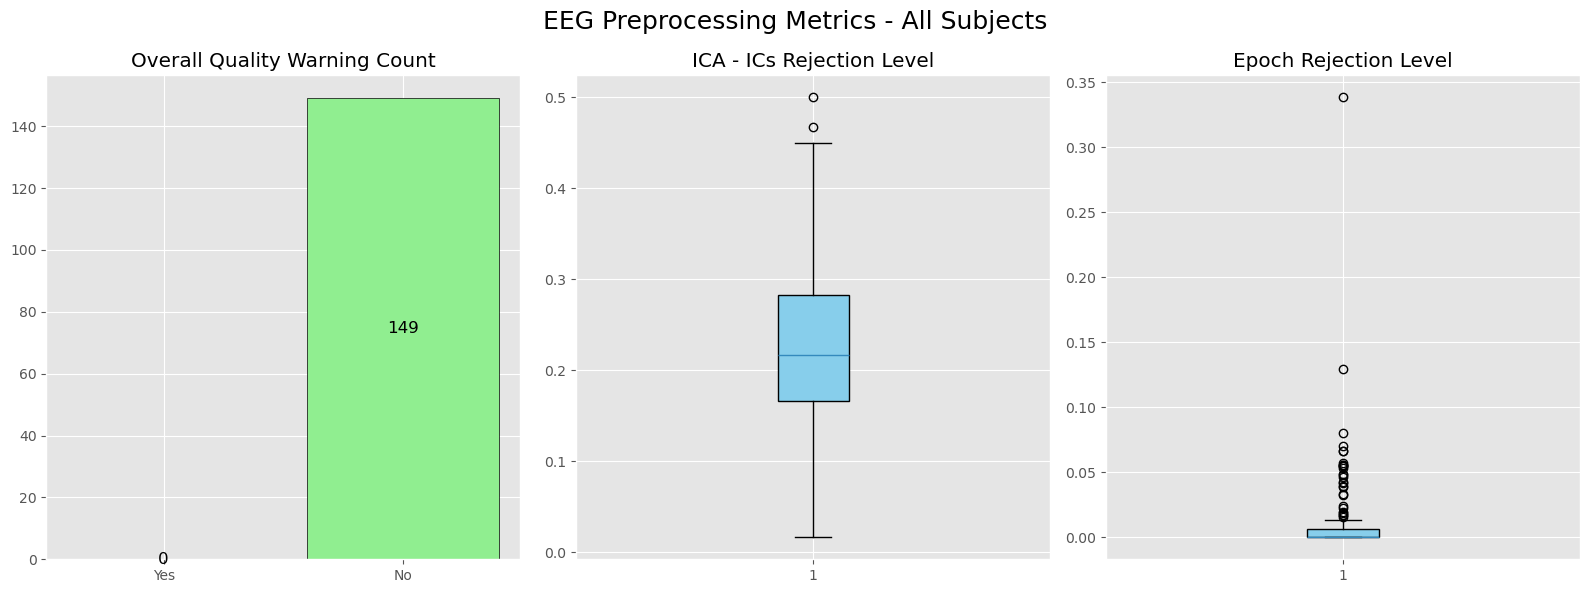

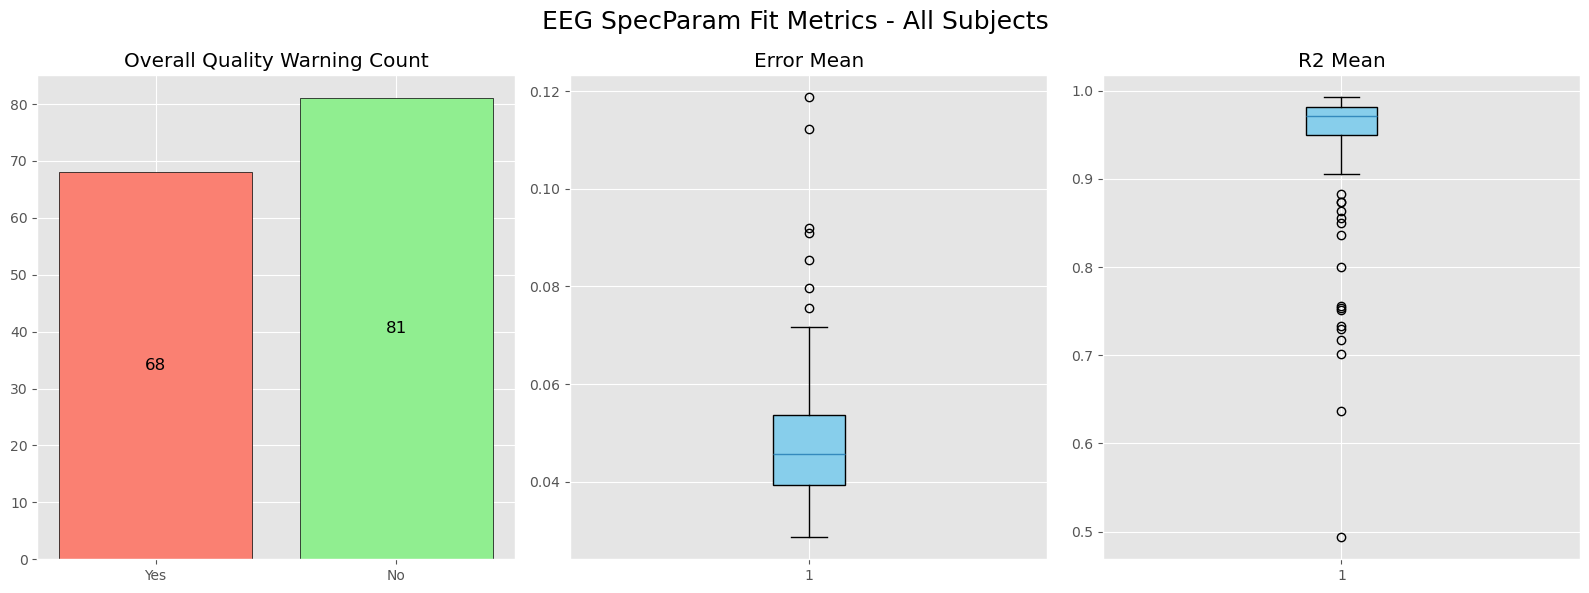

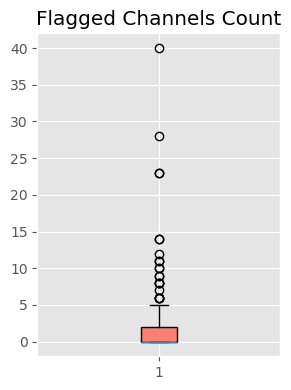

In [11]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Selection Run: {run_name}"
summary = summary + f"\n-   Feature Selection Params: {run_details['extraction_params']}"
summary = summary + f"\n-   Model Training Params: {run_details['model_training_params']}"

print(f'{summary}\n')

# Processing Metrics
print('EEG Processing Results')
print(eeg_processing_results_df.shape)
display(eeg_processing_results_df.head())

print(f'Null Fits: {sum(eeg_processing_results_df["chn_null_fits"])}')
eeg_preprocess_results_plot(eeg_processing_results_df)
eeg_specparam_results_plot(eeg_processing_results_df)


Study Subjects
(149, 5)


,study_name,subject_id,pd,age,gender
0,IOWA_Rest,sub-001,1,80,M
1,IOWA_Rest,sub-002,1,81,M
2,IOWA_Rest,sub-003,1,68,F
3,IOWA_Rest,sub-004,1,80,M
4,IOWA_Rest,sub-005,1,56,M


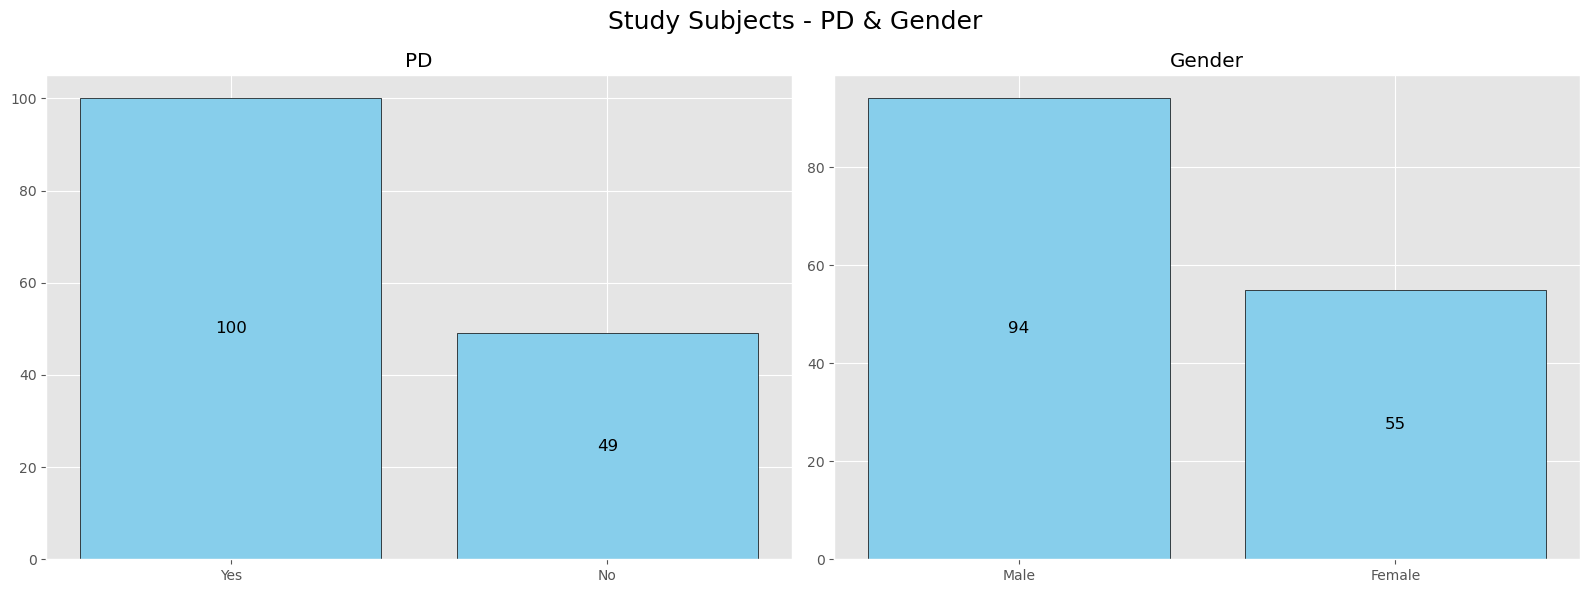

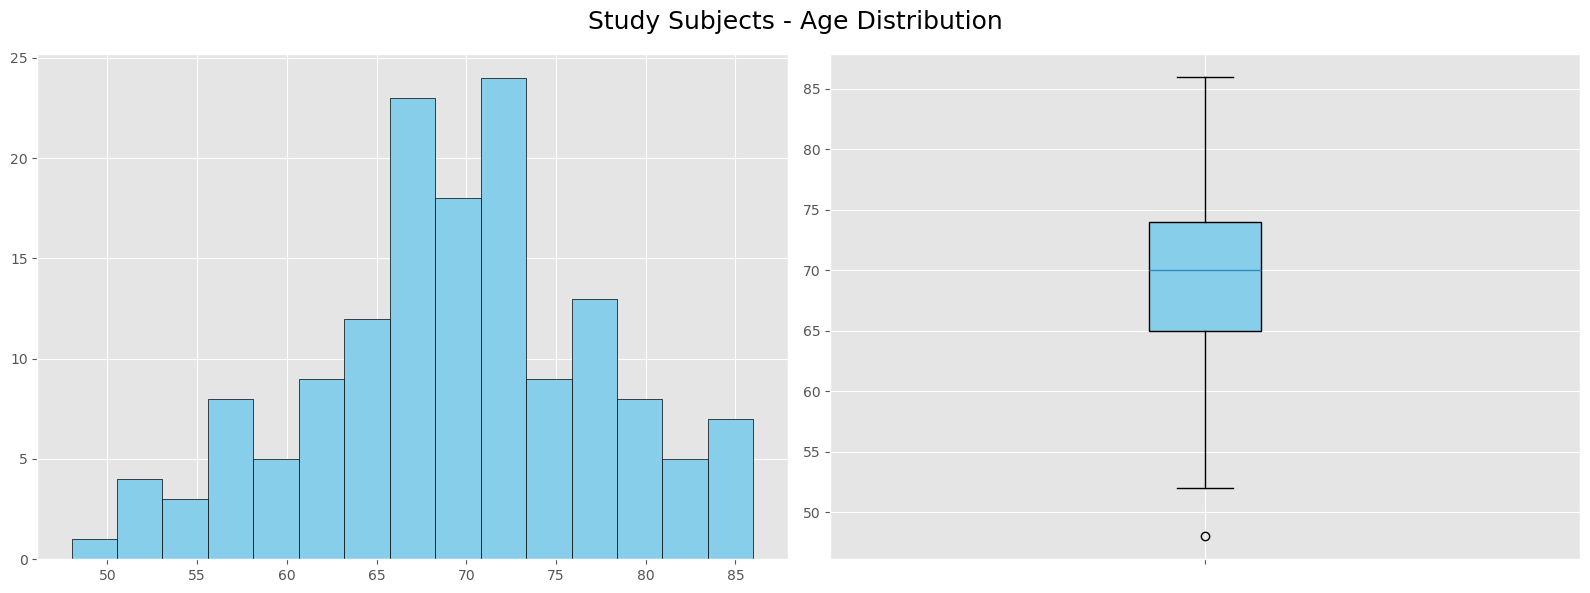

In [12]:
# Study Subjects Summary
print('Study Subjects')
print(study_subjects_df.shape)
display(study_subjects_df.head())

subject_info_plot(study_subjects_df)

In [13]:
# %pip install selenium
# %pip install great_tables[extra]

# from great_tables import GT
# GT(study_subjects_df.head(10)).tab_header(title="Sample Table (First 10 Rows)").fmt_number(columns="value_column").save('temp.png')

In [14]:
# Features Superset 
print('EEG Features Superset')
print(eeg_features_superset_df.shape)
display(eeg_features_superset_df.head())

# Features Flattened 
print('EEG Features Flattened')
print(eeg_features_flattened_df.shape)
display(eeg_features_flattened_df.head())


EEG Features Superset
(9556, 25)


,subject_id,region,channel,offset,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,pw_3,bw_3,cf_4,pw_4,bw_4,cf_5,pw_5,bw_5,error,r_squared
0,sub-001,frontal,NaN,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,0.279289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034690,0.944893
1,sub-001,central,NaN,-13.225069,0.001710,6.783147,0.275626,2.065892,24.000274,0.400991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042600,0.831166
2,sub-001,posterior,NaN,-11.600760,1.001592,7.041851,0.623959,3.047822,10.205950,0.359989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035003,0.990475
3,sub-001,NaN,Fp1,-12.200923,0.073338,5.000001,0.424577,6.068113,25.200637,0.384810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076825,0.732550
4,sub-001,NaN,Fz,-11.761049,0.695183,6.972525,0.476730,3.088743,9.953165,0.262546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029025,0.982654


EEG Features Flattened
(149, 1478)


,subject_id,pd,age,gender,region_frontal_offset,region_frontal_exponent,region_frontal_cf_0,region_frontal_pw_0,region_frontal_bw_0,region_frontal_cf_1,...,channel_Iz_pw_3,channel_Iz_bw_3,channel_Iz_cf_4,channel_Iz_pw_4,channel_Iz_bw_4,channel_Iz_cf_5,channel_Iz_pw_5,channel_Iz_bw_5,channel_Iz_error,channel_Iz_r_squared
0,sub-001,1,80,M,-12.147619,0.481923,7.124575,0.382933,3.661685,25.565920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-002,1,81,M,-10.770975,1.462089,6.318833,0.594900,2.065198,16.200240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-003,1,68,F,-11.282055,1.181536,11.545416,0.942409,12.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-004,1,80,M,-11.485494,1.369393,6.137473,0.844282,4.052694,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-005,1,56,M,-12.037372,0.511769,6.566139,0.435743,2.000000,13.261402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


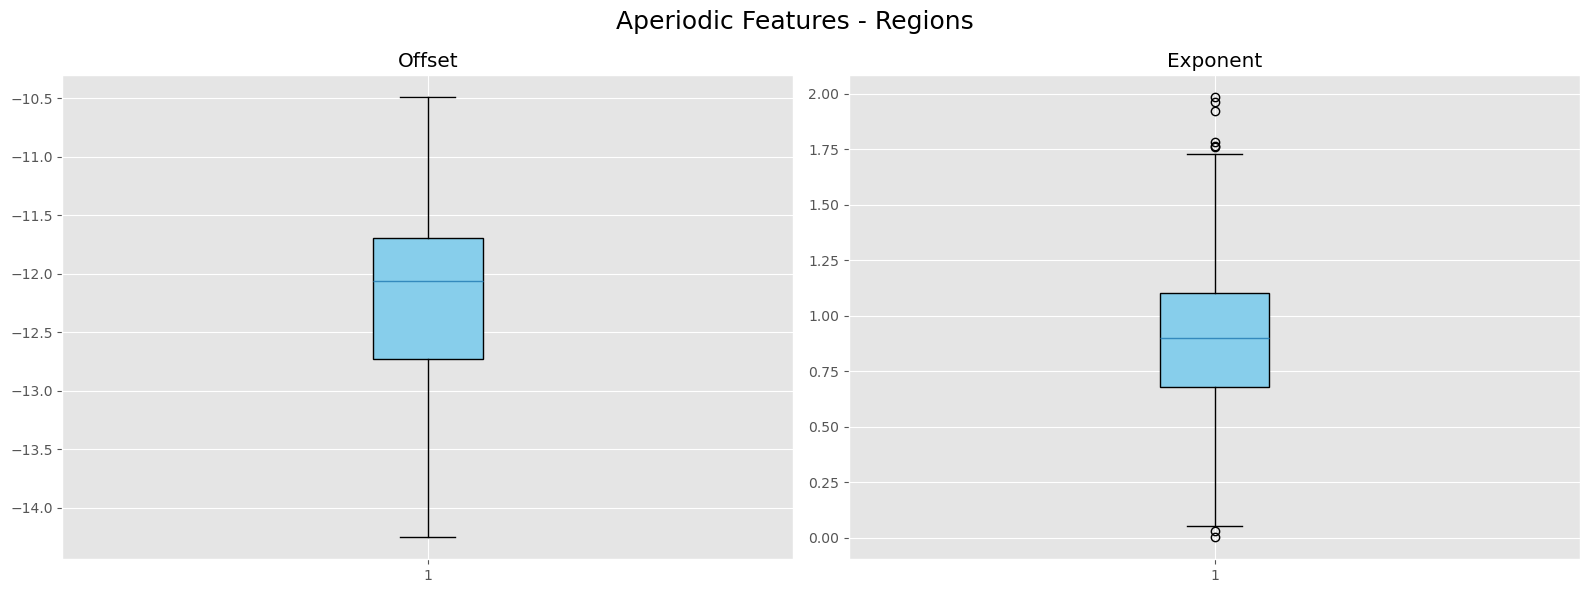

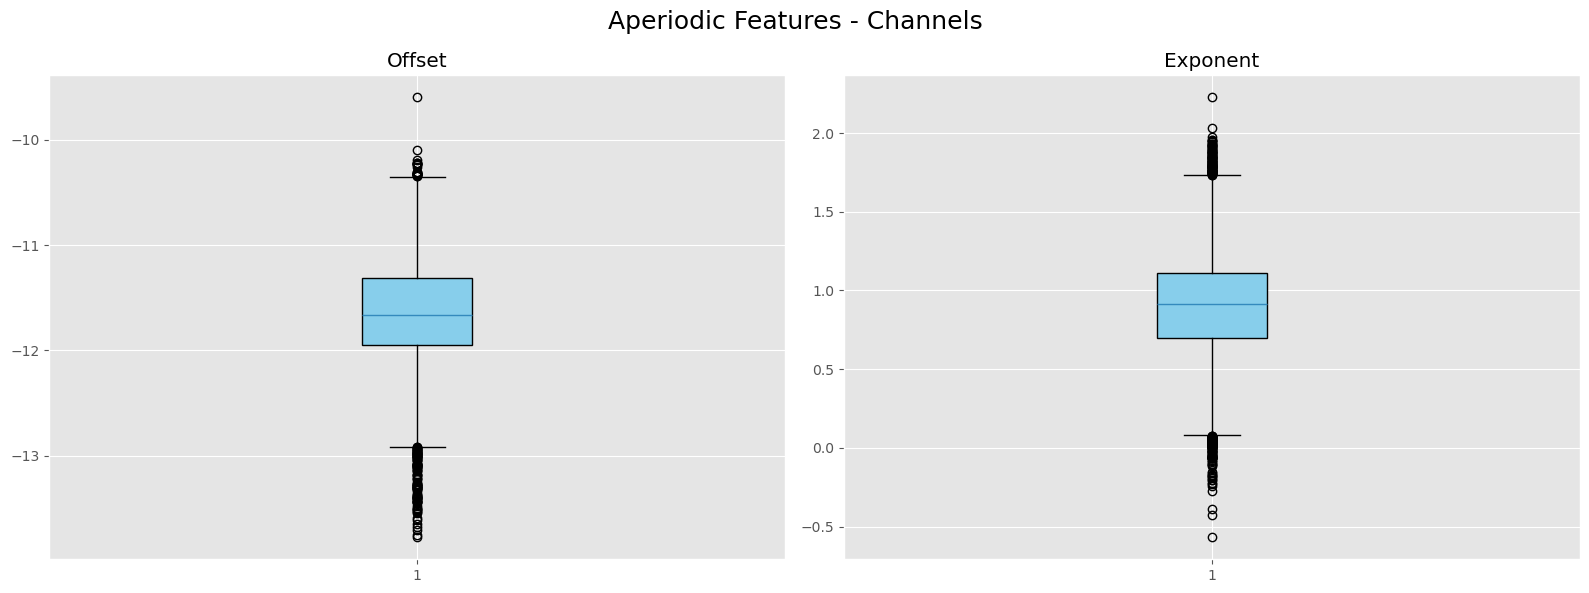

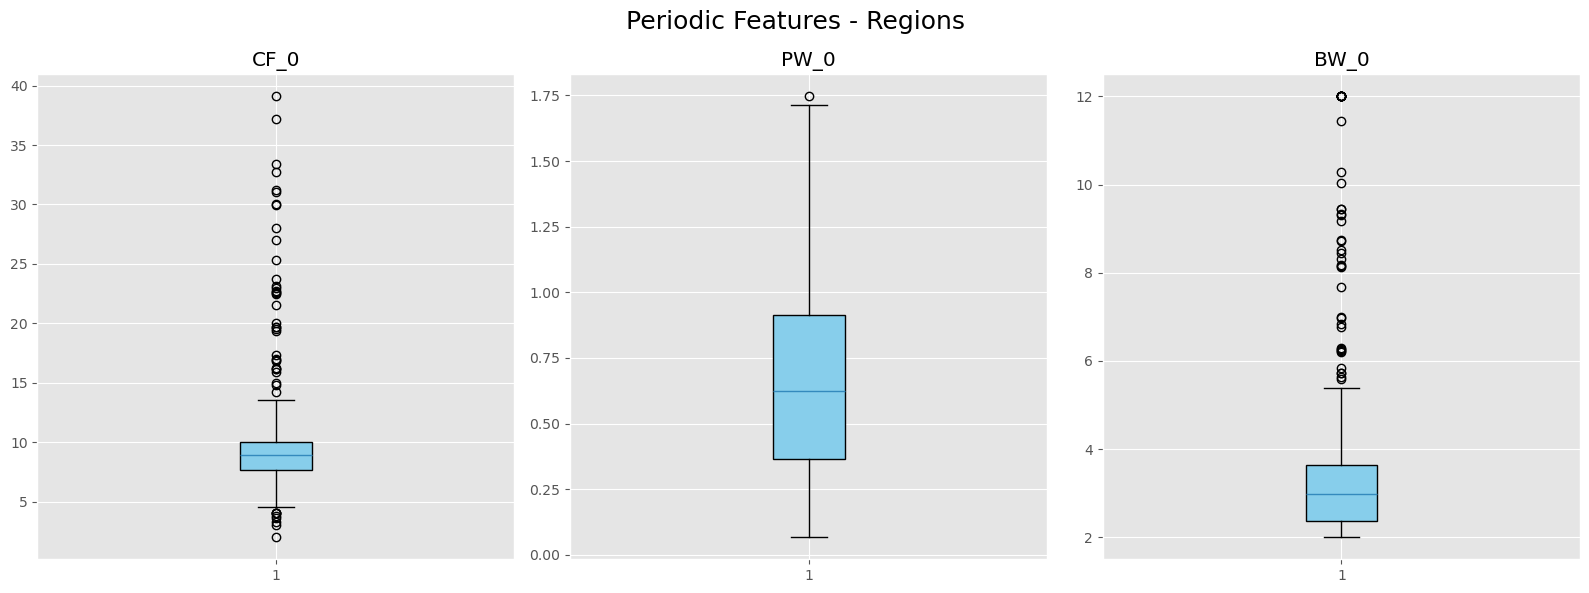

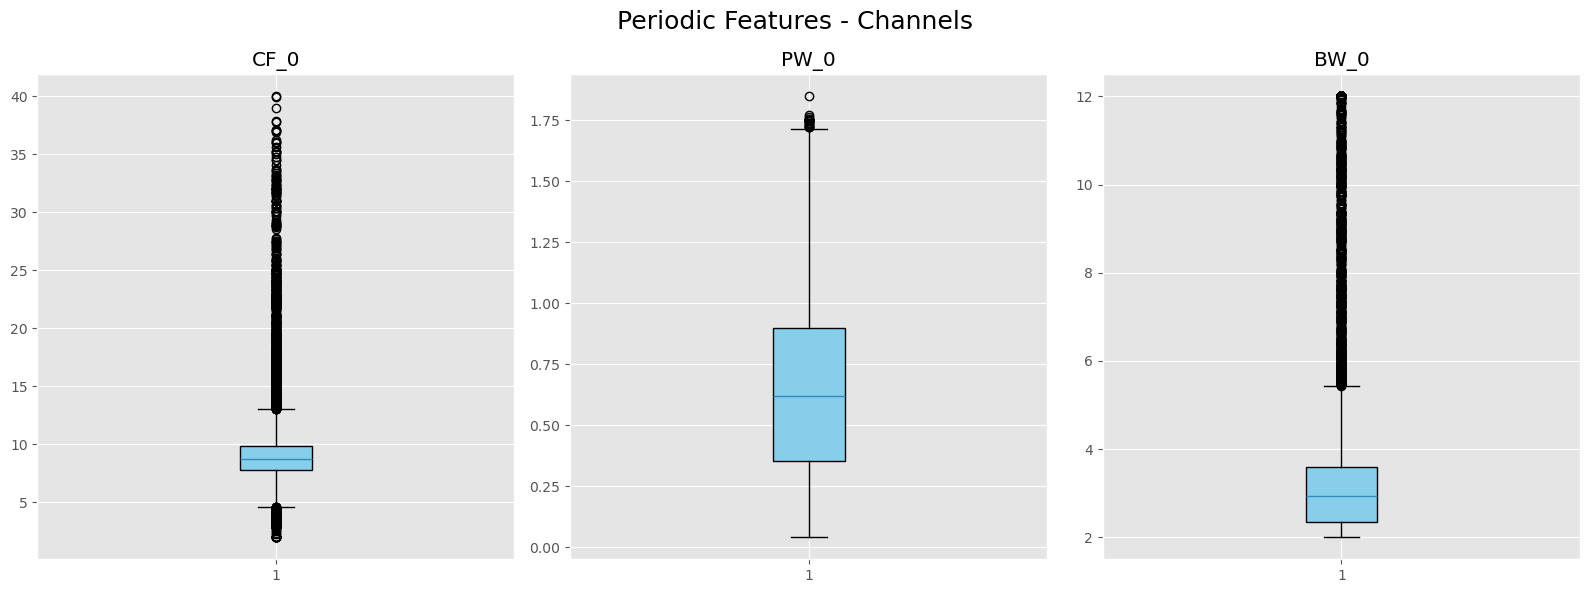

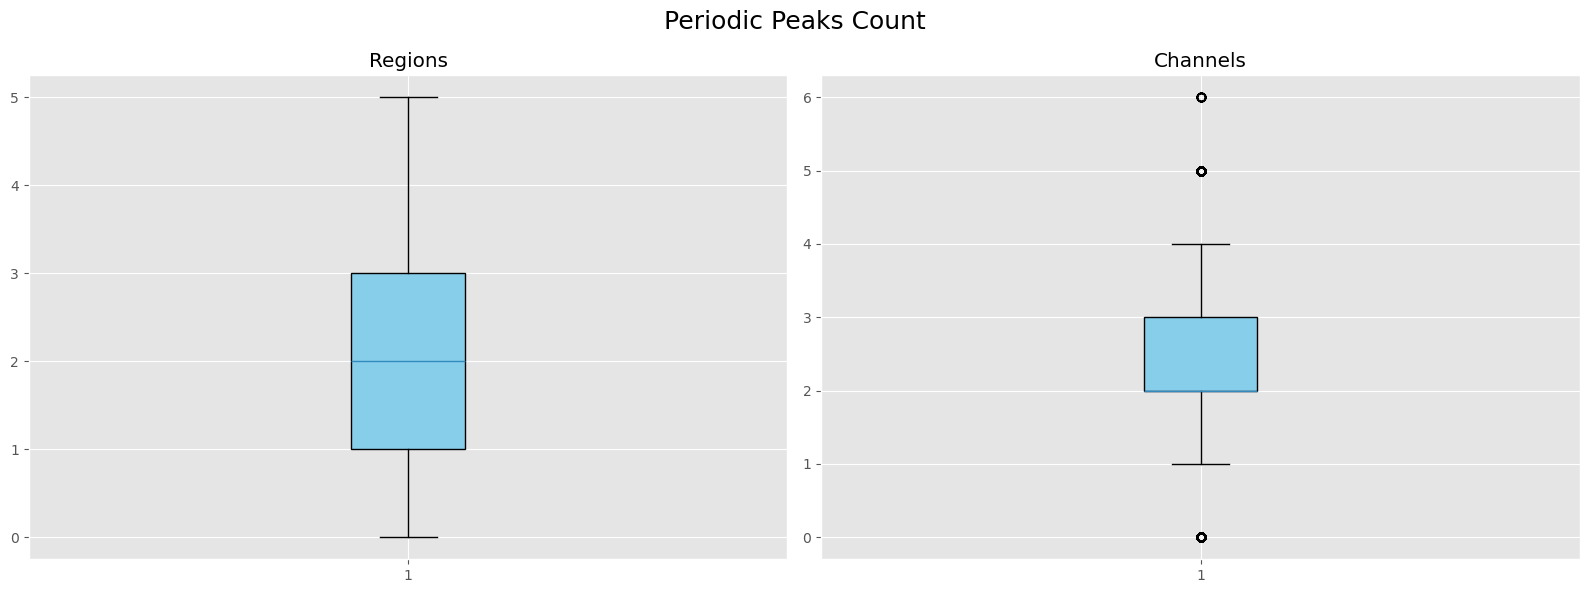

In [15]:
# Features - At Region & Channel Detail Level
#

regions_df = eeg_features_superset_df[eeg_features_superset_df['channel'].isnull()].copy()
channels_df = eeg_features_superset_df[eeg_features_superset_df['region'].isnull()].copy()

aperiodic_features_plot(regions_df, 'Regions')
aperiodic_features_plot(channels_df, 'Channels')

periodic_features_plot(regions_df, 'Regions')
periodic_features_plot(channels_df, 'Channels')

periodic_peaks_plot(eeg_features_superset_df)

# Run: 2. Feature Selection, Data Cleaning & Pipeline Save

In [16]:
# Separate X features and y target
# For Data Pipeline & ML Model Training
#

target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()

# Data Split : Training & Test, 80:20. NB cross-validation will be performed using Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Different split?
# split by *subjects*, not by raw rows
# train_subj, test_subj = train_test_split(subjects, stratify=labels,
#                                          test_size=.3, random_state=42)
# X_train = eeg_long[eeg_long.subject_id.isin(train_subj)]
# X_test  = eeg_long[eeg_long.subject_id.isin(test_subj)]
# y_train = labels.loc[train_subj].values
# y_test  = labels.loc[test_subj].values

In [17]:
# Feature Selection using a Custom Transformer class
#

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self, features_detail_level='default', selected_features='default'):
        # Parameters for the selection
        self.features_detail_level = features_detail_level
        self.selected_features = selected_features

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Filter out features according to detail level, ie region or channel
        drop_cols =[]
        if self.features_detail_level == 'region':
            drop_cols = drop_cols + [col for col in X_temp_df.columns if col.startswith('channel')]
        elif self.features_detail_level == 'channel':
            drop_cols = drop_cols +[col for col in X_temp_df.columns if col.startswith('region')]
        else:
            raise ValueError(f'Detail of {self.features_detail_level} is not region or channel')
        X_temp_df = X_temp_df.drop(columns=drop_cols, errors='ignore')
        
        # Only retain columns whose names contain any of the selected features
        X_temp_df = X_temp_df[[col for col in X_temp_df.columns if any(feat in col for feat in self.selected_features)]]
       
        self.selected_features_ = list(X_temp_df)
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Apply feature selection
        return X[self.selected_features_]


In [18]:
# Features Selection & Cleaning Pipeline Establish & Train & Save
#

# TODO: Compare no scaling at all and model performance
# TODO: Different scaling approaches?

# Transformer for Features Selection
detail_level = extraction_params['features_detail_level']
selected_features = []
if extraction_params['subject_meta_include']: selected_features += ['age', 'gender']
if extraction_params['aperiodic_include']: selected_features += ['offset', 'exponent']
if extraction_params['periodic_include']: selected_features += ['pw', 'bw', 'cf']

feature_selector =  FeatureSelection(detail_level, selected_features)

# Sub pipeline for numerical and categorical transformations
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    # ('scale_num', RobustScaler())
    ('scale_num', RobustScaler(quantile_range=(10.0, 90.0)))
    ])
cat_pipeline = Pipeline([
    # ("impute", SimpleImputer(strategy="most_frequent")),
    # ("encode_cat", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ('encode_cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))
    ])
cols_transform = ColumnTransformer([
    ('numeric', num_pipeline, make_column_selector(dtype_include=['float64', 'int64'])),
    ('categorical', cat_pipeline, make_column_selector(dtype_include='object'))
])

# Setup & train/fit the overall pipeline
features_prep_pipeline = Pipeline([
    ('features_selection', feature_selector),
    # ('drop_columns', dropper),
    ('data_preprocess', cols_transform)
    ])  
features_prep_pipeline.fit(X_train)

# Save the Data Prep Pipeline
# Using cloudpickle in order to handle the custom transformer class
cloudpickle.dump(features_prep_pipeline, open(run_results_path + '/' + 'features_prep_pipeline.pkl', 'wb'))


In [19]:
# Apply the transformations to X data & Inspect Results
#

X_train_transformed = features_prep_pipeline.transform(X_train)
X_test_transformed = features_prep_pipeline.transform(X_test)

# TODO: Examine the impact of scaling etc more closely eg some boxplots before and after .... how well has eg scaling worked?

# Before & After Datasets
print("Features Extraction vs Transformed Data Shapes")
print(f'- Original Features Selection: {eeg_features_flattened_df.shape}')
print(f'- Original X_train: {X_train.shape} and y_train: {y_train.shape}')
print(f'- Original X_test: {X_test.shape} and y_test: {y_test.shape}')
print(f'- Transformed X_train: {X_train_transformed.shape}')
print(f'- Transformed X_test: {X_test_transformed.shape}')

# Data Pipeline - Features Transformed
print("\nTransformed Features:")
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")

feature_names = features_prep_pipeline.named_steps['data_preprocess'].get_feature_names_out()
print(f'Feature Names: {len(feature_names)}')
# print(feature_names)
temp_names_X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
temp_names_X_train_df.reset_index(drop=True, inplace=True)
print(temp_names_X_train_df.shape)
display(temp_names_X_train_df.head())



Features Extraction vs Transformed Data Shapes
- Original Features Selection: (149, 1478)
- Original X_train: (119, 1477) and y_train: (119,)
- Original X_test: (30, 1477) and y_test: (30,)
- Transformed X_train: (119, 8)
- Transformed X_test: (30, 8)

Transformed Features:
- numeric: 7 columns
- categorical: 1 columns
Feature Names: 8
(119, 8)


,numeric__age,numeric__region_frontal_offset,numeric__region_frontal_exponent,numeric__region_central_offset,numeric__region_central_exponent,numeric__region_posterior_offset,numeric__region_posterior_exponent,categorical__gender_M
0,-0.545455,0.475448,0.161104,0.572214,0.391286,0.046767,-0.208375,1.0
1,-0.409091,-0.083866,-0.663923,-0.078959,-0.539277,-0.200241,-0.965147,1.0
2,0.136364,0.036719,-0.165324,-0.182097,-0.753147,-0.114159,-0.683260,1.0
3,0.000000,-0.187012,-0.469335,-0.021736,-0.316958,-0.180725,-0.679640,1.0
4,0.090909,0.064131,-0.209922,-0.169654,-0.567594,-0.156831,-0.414218,1.0


In [20]:
# # Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in features_prep_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

# print("\nColumnTransformer Details:")
# ct = features_prep_pipeline.named_steps['data_preprocess']
# for name, trans, cols in ct.transformers_:
#     print(f"- Transformer: {name}")
#     print(f"    Columns: {cols}")
#     print(f"    Transformer object: {trans}\n")

# print("\nAll Pipeline Parameters")
# for param, value in features_prep_pipeline.get_params().items():
#     print(f"- {param}: {value}")

# Run: 3. Models Training on Processed Data

## Random Forest

In [21]:
# Establish a Model Pipeline - Using Processed Data used in Pipeline Fitting
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [100, 150],                       # Default 100. Number of trees
    'classifier__max_depth': [3, 10, 15],                         # Default none, unlimited ... but don't want to overfit
    # 'classifier__max_features': [0.8, 2],           # Default is sqrt
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']              # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    # scoring='f1'
    # scoring='roc_auc'
    )


# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_randforest = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_randforest.pkl', 'wb'))
cloudpickle.dump(model_randforest, open(run_results_path + '/' + 'model_randforest.pkl', 'wb'))


Model Training Pipeline Steps:
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
All Pipeline Parameters:
- memory: None
- steps: [('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False))]
- transform_input: None
- verbose: False
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
- classifier__bootstrap: True
- classifier__ccp_alpha: 0.0
- classifier__class_weight: None
- classifier__criterion: gini
- classifier__max_depth: None
- classifier__max_features: sqrt
- classifier__max_leaf_nodes: None
- classifier__max_samples: None
- classifier__min_impurity_decrease: 0.0
- classifier__min_samples_leaf: 1
- classifier__min_samples_split: 2
- classifier__min_weight_fraction_leaf: 0.0
- classifier__monotonic_cst: None
- classifier__n_estimators: 100
- classifier__n_jobs: -1
- classifier__oob_score: False
- classifier__random_state: 42
- classifier__verbose: False
- classifier__warm_start: False


Grid Search R

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
10,1,0.747087,0.098799,0.028160,"{'classifier__criterion': 'gini', 'classifier_..."
6,2,0.741026,0.107898,0.022379,"{'classifier__criterion': 'gini', 'classifier_..."
32,3,0.724921,0.105728,0.017537,"{'classifier__criterion': 'log_loss', 'classif..."
20,3,0.724921,0.110096,0.020067,"{'classifier__criterion': 'entropy', 'classifi..."
31,5,0.724917,0.168651,0.019234,"{'classifier__criterion': 'log_loss', 'classif..."
19,5,0.724917,0.143017,0.025897,"{'classifier__criterion': 'entropy', 'classifi..."
7,7,0.723689,0.153356,0.031425,"{'classifier__criterion': 'gini', 'classifier_..."
11,7,0.723689,0.140659,0.023510,"{'classifier__criterion': 'gini', 'classifier_..."
9,9,0.720977,0.145637,0.028264,"{'classifier__criterion': 'gini', 'classifier_..."
18,10,0.720710,0.100188,0.020751,"{'classifier__criterion': 'entropy', 'classifi..."


Best Model: 
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, n_jobs=-1,
                                        random_state=42, verbose=False))])


Model Prediction Results
Run Time: 0.0301
Classification Results
-----------
Recall (Sensitivity, TP Rate): 0.8947
Precision: 0.6538
F1 Score 0.7556
Specificity: 0.1818
MCC: 0.1085
-----------
Accuracy: 0.6333
Fall Out (FPR): 0.8182
Hamming Loss 0.3667
ROC-AUC Score 0.5885
Gini Index: 0.1770


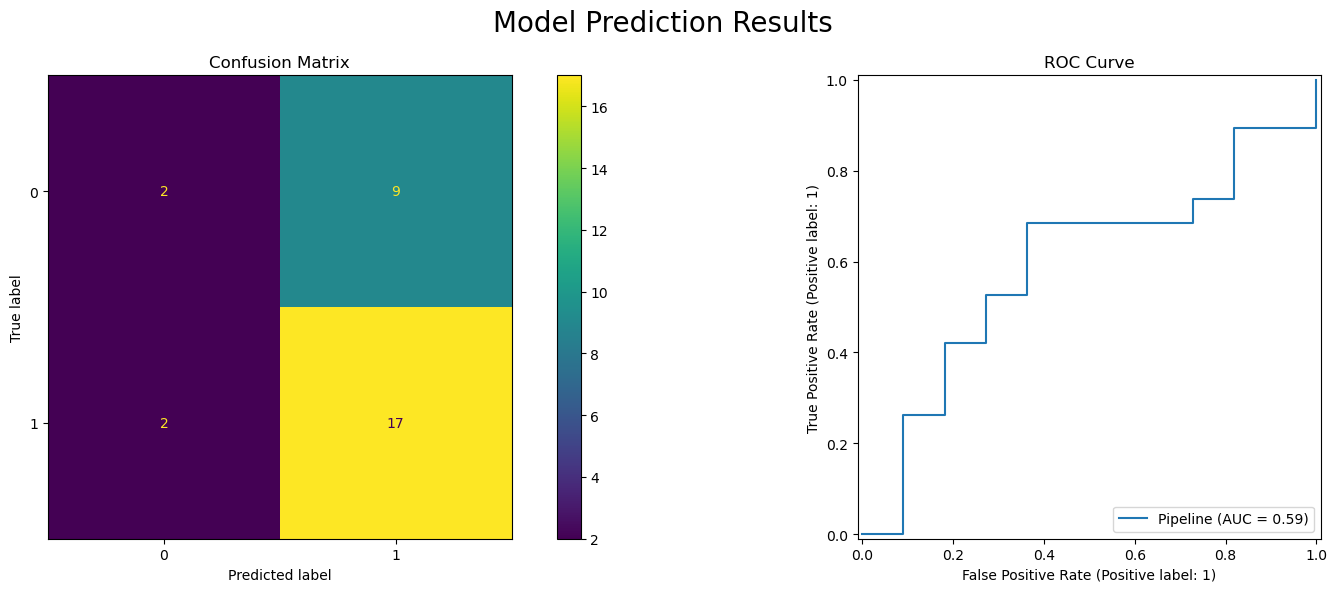

(30, 3)


,Prediction,Predicted_Probability,True
73,1,0.78,1
18,1,0.80,1
117,1,0.73,0
78,1,0.95,1
76,1,0.78,1
31,1,0.94,1
64,1,0.94,1
140,1,0.67,0
68,1,0.54,1
82,1,0.93,1


Mismatches


,Prediction,Predicted_Probability,True
117,1,0.73,0
140,1,0.67,0
109,1,0.77,0
19,0,0.76,1
136,1,0.79,0
69,0,0.80,1
127,1,0.99,0
128,1,0.60,0
144,1,0.73,0
110,1,0.71,0


Importance
(8, 2)


,Feature,Importance
1,numeric__region_frontal_offset,0.173708
2,numeric__region_frontal_exponent,0.157494
5,numeric__region_posterior_offset,0.132447
6,numeric__region_posterior_exponent,0.130589
4,numeric__region_central_exponent,0.127594


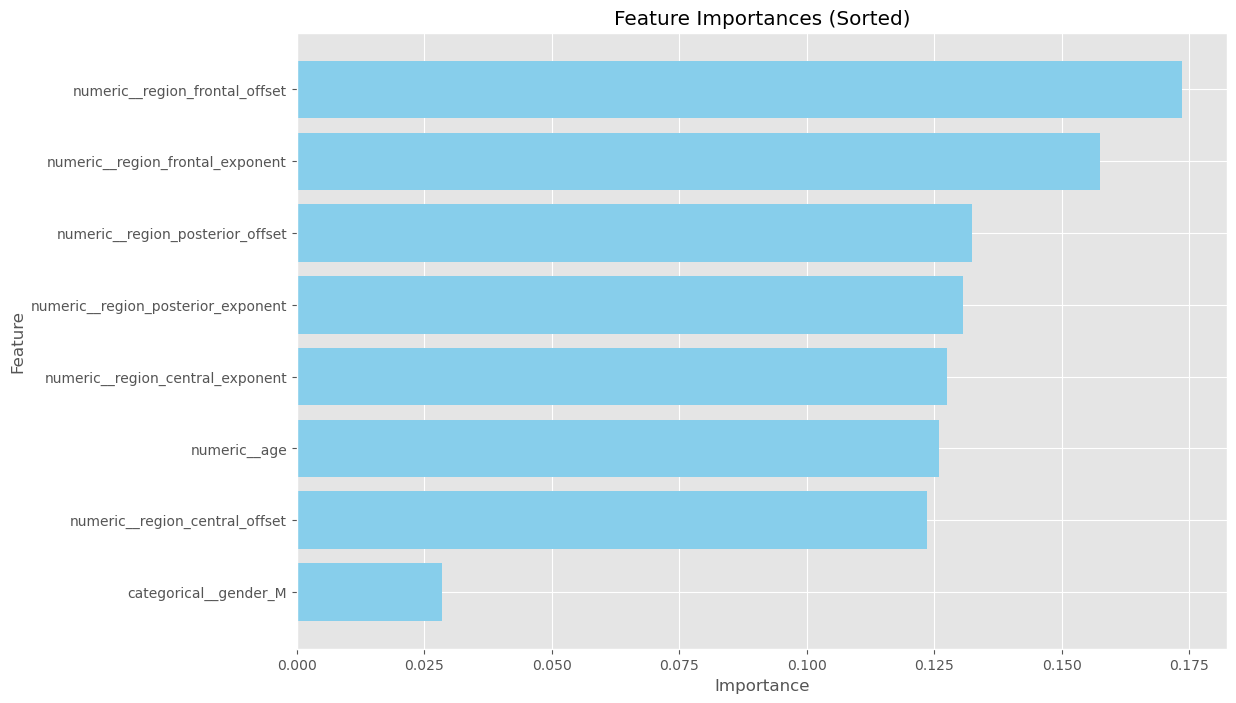

  0%|          | 0/30 [00:00<?, ?it/s]

SHAP Values Importance
(8, 2)


,feature,importance_%
0,numeric__region_frontal_offset,26.648933
1,numeric__region_posterior_exponent,15.771613
2,numeric__region_frontal_exponent,14.138677
3,numeric__age,13.240387
4,numeric__region_posterior_offset,10.127770


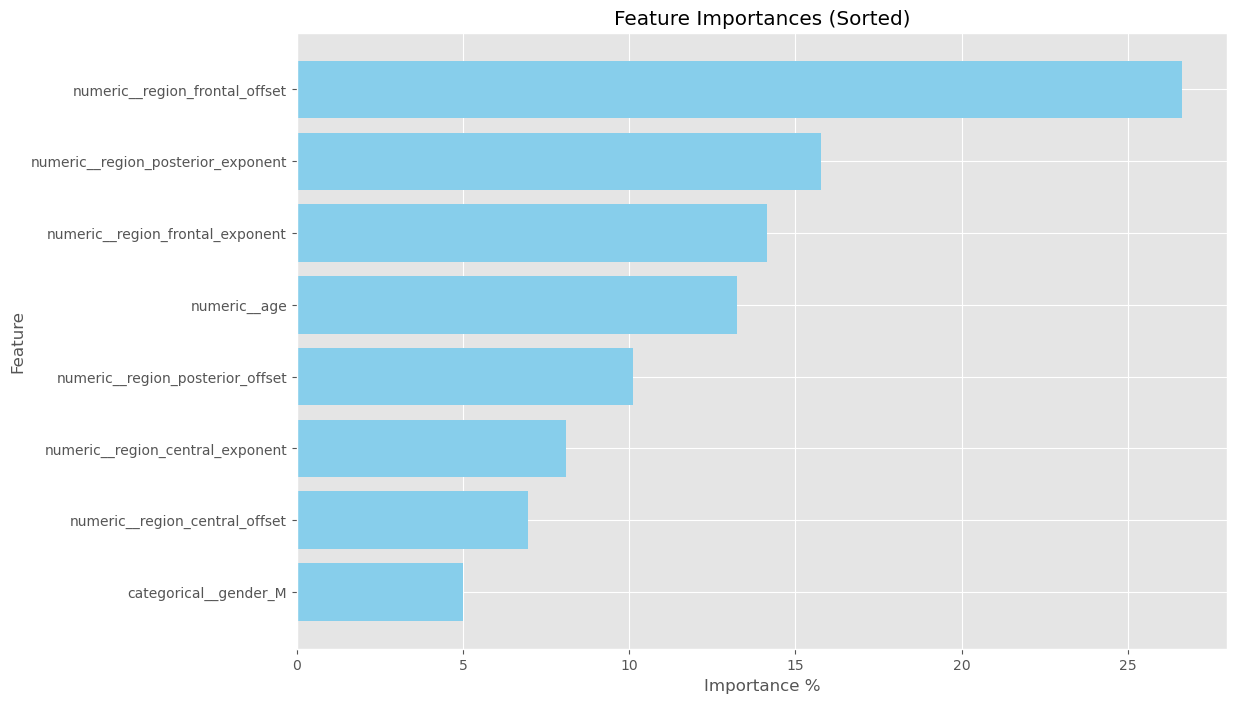

In [22]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_randforest.predict(X_test_transformed)
y_probablities = model_randforest.predict_proba(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_randforest, X_test_transformed, y_test, y_pred)

# Assign Probabilities to Each Prediction
get_prediction_probabilities(y_pred, y_probablities, y_test)


# Feature Importance / Contribution
feature_importance(model_randforest, features_prep_pipeline)
features_importance_shap_df = get_shap_importance(X_train_transformed, X_test_transformed, model_randforest, features_prep_pipeline)



In [23]:
# def make_predictions_custom_threshold(model, X, threshold=0.5):
#     """
#     Make predictions with custom threshold to minimize false positives
#     Higher threshold = fewer false positives, but potentially lower recall
#     """
#     probabilities = model.predict_proba(X)
#     predictions = (probabilities[:, 1] >= threshold).astype(int)
#     return predictions, probabilities


# predictions, probabilities = make_predictions_custom_threshold(
#     model_randforest, X_test_transformed, threshold=0.65
# )

# print(predictions)
# print(probabilities[:10])

# classification_metrics(model_randforest, X_test_transformed, y_test, predictions)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score:", grid_search.best_score_)

In [24]:
# from sklearn.metrics import precision_score, recall_score

# def find_optimal_threshold(model, X, y_true, metric='precision'):
#     """Find threshold that optimizes a specific metric"""
#     probabilities = model.predict_proba(X)[:, 1]
#     thresholds = np.arange(0.1, 1.0, 0.05)
    
#     best_threshold = 0.5
#     best_score = 0
    
#     for threshold in thresholds:
#         preds = (probabilities >= threshold).astype(int)
        
#         if metric == 'precision':
#             score = precision_score(y_true, preds, zero_division=0)
#         elif metric == 'recall':
#             score = recall_score(y_true, preds, zero_division=0)
        
#         if score > best_score:
#             best_score = score
#             best_threshold = threshold
    
#     return best_threshold, best_score

# best_theshold, best_score = find_optimal_threshold(model_randforest, X_test_transformed,y_test)
# print(best_theshold, best_score)

## Logistic Regression

In [25]:
# Logistic Regression

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', LogisticRegression(random_state=42))
    ])

grid_params = {
    'classifier__solver': ['saga','liblinear', 'lbfgs'],          # Default is lbfgs. Saga with L1 or l2. Large dataset. liblinear small datasets, binary classifications
    'classifier__penalty': ['l1', 'l2'],                        # Types of regulaisation
    'classifier__C': [1, 10, 100],                 # Default 1. Strength of regularisation, smaller is stronger
    'classifier__class_weight': [None, 'balanced'],           # Default None. Balanced seems to prevent near zero True predictions
    'classifier__max_iter': [1000, 2500, 5000]                      # Default 100. 
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_logreg = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_logreg.pkl', 'wb'))
cloudpickle.dump(model_logreg, open(run_results_path + '/' + 'model_logreg.pkl', 'wb'))


Model Training Pipeline Steps:
- classifier: LogisticRegression(random_state=42)
All Pipeline Parameters:
- memory: None
- steps: [('classifier', LogisticRegression(random_state=42))]
- transform_input: None
- verbose: False
- classifier: LogisticRegression(random_state=42)
- classifier__C: 1.0
- classifier__class_weight: None
- classifier__dual: False
- classifier__fit_intercept: True
- classifier__intercept_scaling: 1
- classifier__l1_ratio: None
- classifier__max_iter: 100
- classifier__multi_class: deprecated
- classifier__n_jobs: None
- classifier__penalty: l2
- classifier__random_state: 42
- classifier__solver: lbfgs
- classifier__tol: 0.0001
- classifier__verbose: 0
- classifier__warm_start: False


Grid Search Results
Score: 0.8002. Mean: 0.7503 and STD 0.0447
Search Took: 0.39 seconds
Best Parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best C-V Score: 0.800162337

/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
90 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/eeg_ml_pipe

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
63,1,0.800162,0.001644,0.001327,"{'classifier__C': 10, 'classifier__class_weigh..."
71,1,0.800162,0.002299,0.001846,"{'classifier__C': 10, 'classifier__class_weigh..."
59,1,0.800162,0.004117,0.001998,"{'classifier__C': 10, 'classifier__class_weigh..."
58,1,0.800162,0.001064,0.001271,"{'classifier__C': 10, 'classifier__class_weigh..."
57,1,0.800162,0.003354,0.001744,"{'classifier__C': 10, 'classifier__class_weigh..."
70,1,0.800162,0.001596,0.001357,"{'classifier__C': 10, 'classifier__class_weigh..."
69,1,0.800162,0.001729,0.001742,"{'classifier__C': 10, 'classifier__class_weigh..."
64,1,0.800162,0.002055,0.001687,"{'classifier__C': 10, 'classifier__class_weigh..."
65,1,0.800162,0.002158,0.003728,"{'classifier__C': 10, 'classifier__class_weigh..."
22,10,0.799532,0.001635,0.001787,"{'classifier__C': 1, 'classifier__class_weight..."


Best Model: 
Pipeline(steps=[('classifier',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='saga'))])


Model Prediction Results
Run Time: 0.0004
Classification Results
-----------
Recall (Sensitivity, TP Rate): 0.5789
Precision: 0.7333
F1 Score 0.6471
Specificity: 0.6364
MCC: 0.2075
-----------
Accuracy: 0.6000
Fall Out (FPR): 0.3636
Hamming Loss 0.4000
ROC-AUC Score 0.7416
Gini Index: 0.4833


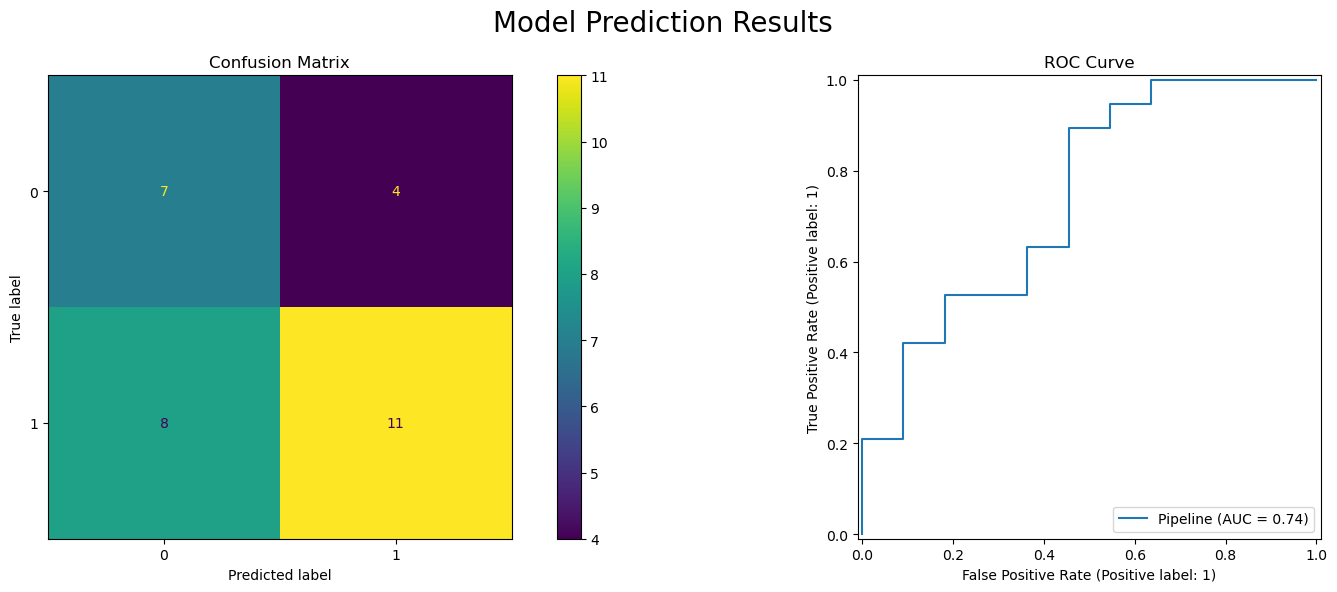

(30, 3)


,Prediction,Predicted_Probability,True
73,0,0.22,1
18,1,0.80,1
117,0,0.27,0
78,1,0.95,1
76,1,0.78,1
31,1,0.94,1
64,1,0.94,1
140,0,0.33,0
68,0,0.46,1
82,1,0.93,1


Mismatches


,Prediction,Predicted_Probability,True
73,0,0.22,1
68,0,0.46,1
109,1,0.77,0
36,0,0.47,1
19,0,0.76,1
56,0,0.06,1
69,0,0.80,1
55,0,0.42,1
127,1,0.99,0
110,1,0.71,0


  0%|          | 0/30 [00:00<?, ?it/s]

SHAP Values Importance
(8, 2)


,feature,importance_%
0,numeric__region_frontal_offset,28.272212
1,numeric__region_posterior_exponent,24.845417
2,categorical__gender_M,12.976697
3,numeric__region_posterior_offset,11.789242
4,numeric__age,10.589323


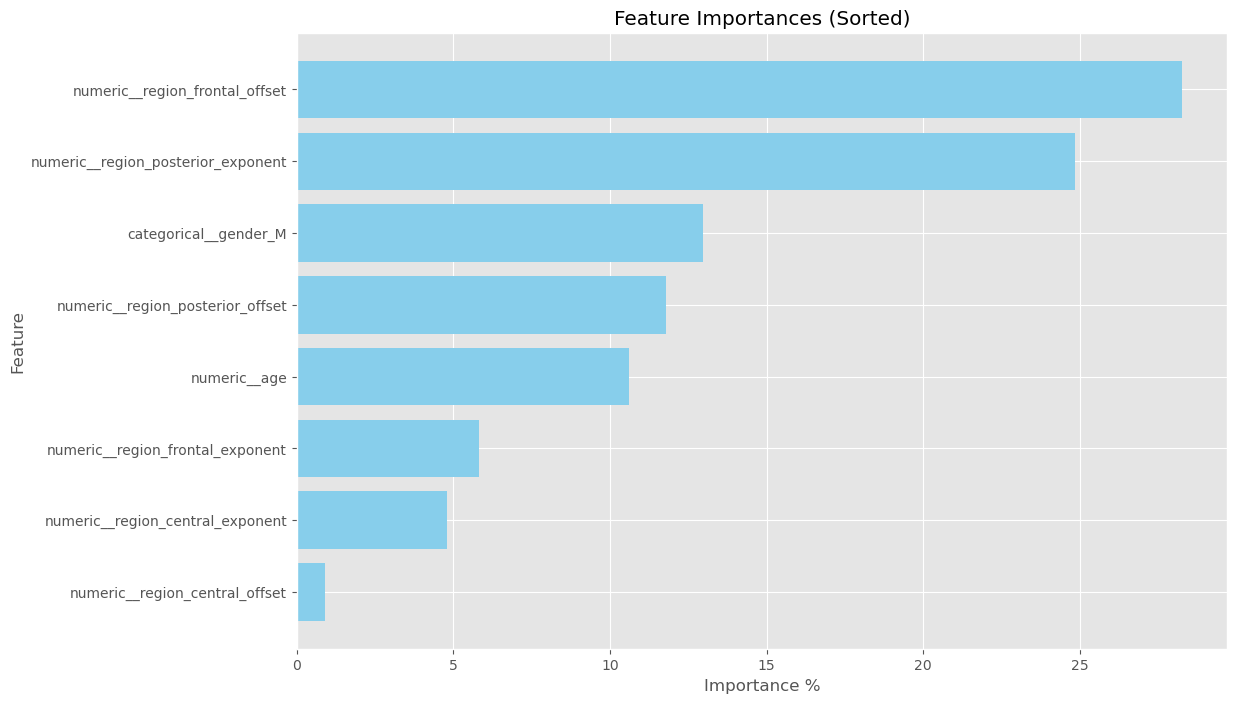

In [26]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_logreg.predict(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_logreg, X_test_transformed, y_test, y_pred)

# Assign Probabilities to Each Prediction
get_prediction_probabilities(y_pred, y_probablities, y_test)

# Feature Importance / Contribution
features_importance_shap_df = get_shap_importance(X_train_transformed, X_test_transformed, model_logreg, features_prep_pipeline)


In [27]:
# # Model Predictions & Evaluation - With Thresholds
# #

# start_time = time.perf_counter()
# y_pred = model_logreg.predict(X_test_transformed)
# y_pred_prob = model_logreg.predict_proba(X_test_transformed)[:,1]
# pred_threshold = 0.6
# y_pred_threshold = (y_pred_prob > pred_threshold).astype(int)
# duration = time.perf_counter() - start_time

# # for i in range(25):
# #     print(f' Binary: {y_pred[i]} vs Prob: {y_pred_prob[i]:.2f} vs {y_pred_threshold[i]}')

# # Evaluate Prediction Results
# print('Model Prediction Results')
# print(f'Run Time: {duration:.4f}')
# classification_metrics(model_logreg, X_test_transformed, y_test, y_pred_threshold)

## MLP Classifier

In [28]:
# MLP Classifier

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', MLPClassifier(random_state=42))
    ])

grid_params = {
    'classifier__hidden_layer_sizes': [(50,50), (100,50)],             # Default, single layer of 100
    # 'classifier__hidden_layer_sizes': [(50,), (100,), (50,50)],             # Default, single layer of 100
    'classifier__activation': ['tanh', 'relu'],                      # Default: relu
    # 'classifier__solver': ['adam', 'lbfgs', 'sgd'],                  # Default adam
    'classifier__solver': ['adam'],                  # Default adam
    'classifier__learning_rate_init': [0.00001, 0.0001, 0.001],
    'classifier__alpha': [0.1],                              # default L2, 0.0001,
    # 'classifier__early_stopping': [True],
    'classifier__batch_size': ['auto'],
    'classifier__max_iter': [1000]                            # Default 200
}

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_mlpc = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_mlpc.pkl', 'wb'))
cloudpickle.dump(model_mlpc, open(run_results_path + '/' + 'model_mlpc.pkl', 'wb'))

/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization has

Model Training Pipeline Steps:
- classifier: MLPClassifier(random_state=42)
All Pipeline Parameters:
- memory: None
- steps: [('classifier', MLPClassifier(random_state=42))]
- transform_input: None
- verbose: False
- classifier: MLPClassifier(random_state=42)
- classifier__activation: relu
- classifier__alpha: 0.0001
- classifier__batch_size: auto
- classifier__beta_1: 0.9
- classifier__beta_2: 0.999
- classifier__early_stopping: False
- classifier__epsilon: 1e-08
- classifier__hidden_layer_sizes: (100,)
- classifier__learning_rate: constant
- classifier__learning_rate_init: 0.001
- classifier__max_fun: 15000
- classifier__max_iter: 200
- classifier__momentum: 0.9
- classifier__n_iter_no_change: 10
- classifier__nesterovs_momentum: True
- classifier__power_t: 0.5
- classifier__random_state: 42
- classifier__shuffle: True
- classifier__solver: adam
- classifier__tol: 0.0001
- classifier__validation_fraction: 0.1
- classifier__verbose: False
- classifier__warm_start: False


Grid Search 

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
6,1,0.796429,0.393984,0.002178,"{'classifier__activation': 'relu', 'classifier..."
5,2,0.779041,0.434907,0.002036,"{'classifier__activation': 'tanh', 'classifier..."
11,3,0.770000,0.289395,0.001860,"{'classifier__activation': 'relu', 'classifier..."
2,4,0.762206,0.392641,0.003095,"{'classifier__activation': 'tanh', 'classifier..."
8,5,0.761533,0.310700,0.001641,"{'classifier__activation': 'relu', 'classifier..."
10,6,0.754615,0.521884,0.002321,"{'classifier__activation': 'relu', 'classifier..."
7,7,0.734054,0.414033,0.002643,"{'classifier__activation': 'relu', 'classifier..."
4,8,0.704221,0.269093,0.002672,"{'classifier__activation': 'tanh', 'classifier..."
0,9,0.703922,0.407948,0.003158,"{'classifier__activation': 'tanh', 'classifier..."
1,10,0.701892,0.221524,0.001839,"{'classifier__activation': 'tanh', 'classifier..."


Best Model: 
Pipeline(steps=[('classifier',
                 MLPClassifier(alpha=0.1, hidden_layer_sizes=(50, 50),
                               learning_rate_init=1e-05, max_iter=1000,
                               random_state=42))])


Model Prediction Results
Run Time: 0.0007
Classification Results
-----------
Recall (Sensitivity, TP Rate): 0.3684
Precision: 0.8750
F1 Score 0.5185
Specificity: 0.9091
MCC: 0.3024
-----------
Accuracy: 0.5667
Fall Out (FPR): 0.0909
Hamming Loss 0.4333
ROC-AUC Score 0.6699
Gini Index: 0.3397


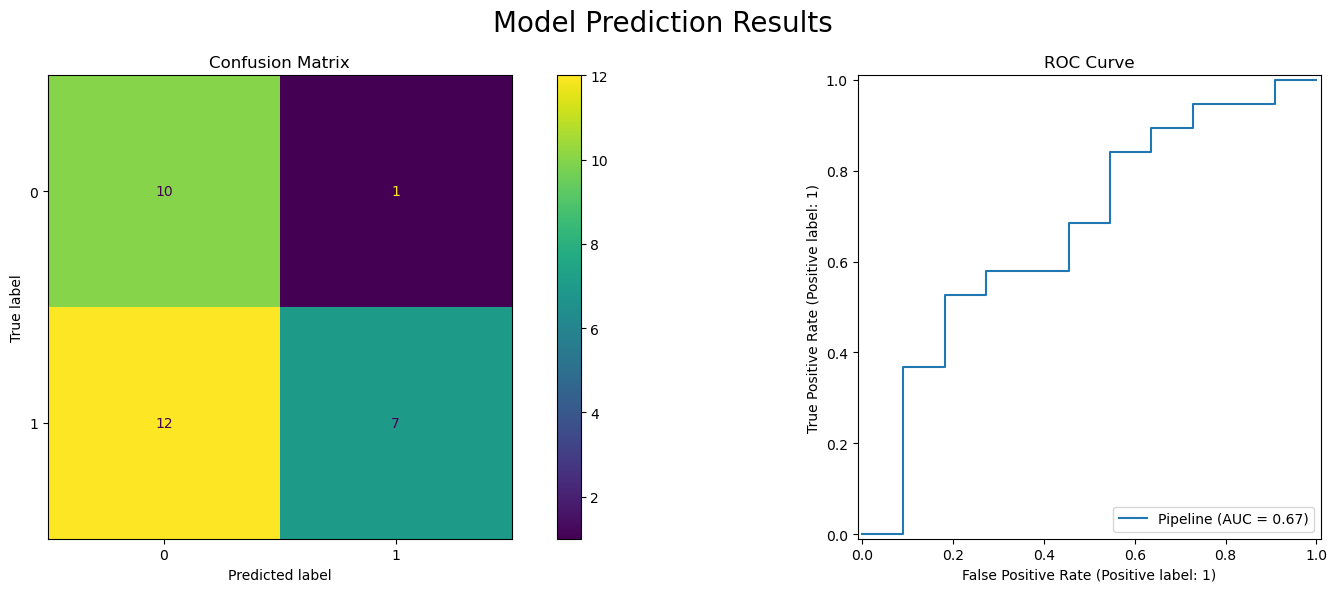

(30, 3)


,Prediction,Predicted_Probability,True
73,1,0.78,1
18,0,0.20,1
117,0,0.27,0
78,1,0.95,1
76,0,0.22,1
31,1,0.94,1
64,1,0.94,1
140,0,0.33,0
68,1,0.54,1
82,1,0.93,1


Mismatches


,Prediction,Predicted_Probability,True
18,0,0.20,1
76,0,0.22,1
12,0,0.37,1
36,0,0.47,1
9,0,0.26,1
19,0,0.76,1
69,0,0.80,1
55,0,0.42,1
29,0,0.10,1
26,0,0.17,1


  0%|          | 0/30 [00:00<?, ?it/s]

SHAP Values Importance
(8, 2)


,feature,importance_%
0,numeric__region_posterior_offset,20.291255
1,numeric__region_frontal_offset,18.245512
2,numeric__region_central_exponent,17.242904
3,numeric__age,15.544103
4,numeric__region_frontal_exponent,13.439524


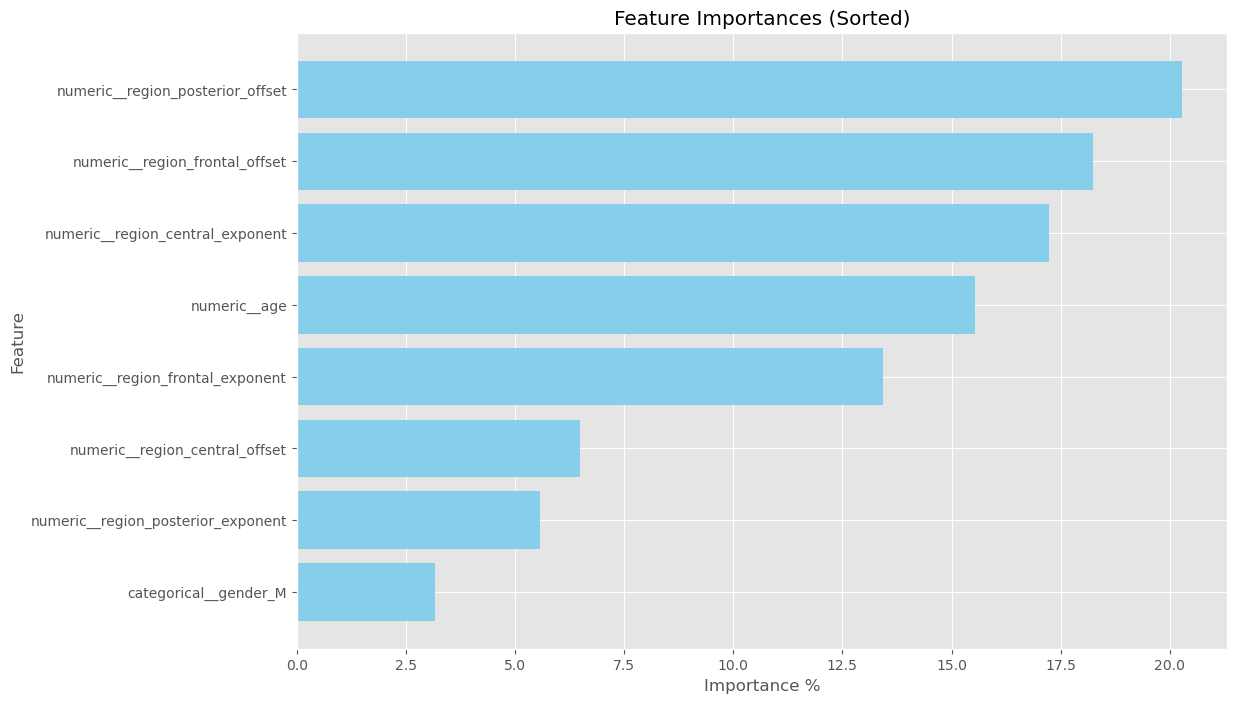

In [29]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_mlpc.predict(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_mlpc, X_test_transformed, y_test, y_pred)

# Assign Probabilities to Each Prediction
get_prediction_probabilities(y_pred, y_probablities, y_test)

# Feature Importance / Contribution
features_importance_shap_df = get_shap_importance(X_train_transformed, X_test_transformed, model_mlpc, features_prep_pipeline)


In [30]:
# # Model Predictions & Evaluation - With Thresholds
# #

# start_time = time.perf_counter()
# y_pred = model_mlpc.predict(X_test_transformed)
# y_pred_prob = model_mlpc.predict_proba(X_test_transformed)[:,1]
# pred_threshold = 0.6
# y_pred_threshold = (y_pred_prob > pred_threshold).astype(int)
# duration = time.perf_counter() - start_time

# # for i in range(25):
# #     print(f' Binary: {y_pred[i]} vs Prob: {y_pred_prob[i]:.2f} vs {y_pred_threshold[i]}')

# # Evaluate Prediction Results
# print('Model Prediction Results')
# print(f'Run Time: {duration:.4f}')
# classification_metrics(model_mlpc, X_test_transformed, y_test, y_pred_threshold)

# Run: 4. Models Training with Combined Grid Search

In [31]:
# Establish a Model Pipeline - With Features Search
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('features_select', FeatureSelection()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'features_select__features_detail_level': ['region', 'channel'],
    'features_select__selected_features': [['exp', 'offset'], ['cf', 'pw']],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 10, None],                       # Default none, unlimited
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']
                            # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

# grid_search = GridSearchCV(
#     model_pipeline, grid_params, 
#     cv=5,
#     scoring='f1'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run

start_time = time.perf_counter()
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

model_randforest_widesearch = grid_search.best_estimator_



Model Training Pipeline Steps:
- features_select: FeatureSelection()
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
All Pipeline Parameters:
- memory: None
- steps: [('features_select', FeatureSelection()), ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False))]
- transform_input: None
- verbose: False
- features_select: FeatureSelection()
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
- features_select__features_detail_level: default
- features_select__selected_features: default
- classifier__bootstrap: True
- classifier__ccp_alpha: 0.0
- classifier__class_weight: None
- classifier__criterion: gini
- classifier__max_depth: None
- classifier__max_features: sqrt
- classifier__max_leaf_nodes: None
- classifier__max_samples: None
- classifier__min_impurity_decrease: 0.0
- classifier__min_samples_leaf: 1
- classifier__min_samples_split: 2
- classifier__min_weight_fraction_leaf: 0.0
- classifier__mo

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
47,1,0.765954,0.242389,0.034280,"{'classifier__criterion': 'gini', 'classifier_..."
31,2,0.756374,0.254618,0.030367,"{'classifier__criterion': 'gini', 'classifier_..."
43,3,0.753993,0.197474,0.037313,"{'classifier__criterion': 'gini', 'classifier_..."
27,4,0.753760,0.212000,0.032922,"{'classifier__criterion': 'gini', 'classifier_..."
73,5,0.752990,0.280566,0.027040,"{'classifier__criterion': 'entropy', 'classifi..."
121,5,0.752990,0.230658,0.027209,"{'classifier__criterion': 'log_loss', 'classif..."
137,7,0.751324,0.255109,0.047876,"{'classifier__criterion': 'log_loss', 'classif..."
89,7,0.751324,0.283052,0.023883,"{'classifier__criterion': 'entropy', 'classifi..."
45,9,0.746851,0.199385,0.028349,"{'classifier__criterion': 'gini', 'classifier_..."
23,10,0.746392,0.235368,0.034544,"{'classifier__criterion': 'gini', 'classifier_..."


Best Model: 
Pipeline(steps=[('features_select',
                 FeatureSelection(features_detail_level='channel',
                                  selected_features=['cf', 'pw'])),
                ('classifier',
                 RandomForestClassifier(n_estimators=175, n_jobs=-1,
                                        random_state=42, verbose=False))])


Model Prediction Results
Run Time: 0.0215
Classification Results
-----------
Recall (Sensitivity, TP Rate): 0.8947
Precision: 0.7727
F1 Score 0.8293
Specificity: 0.5455
MCC: 0.4797
-----------
Accuracy: 0.7667
Fall Out (FPR): 0.4545
Hamming Loss 0.2333
ROC-AUC Score 0.8373
Gini Index: 0.6746


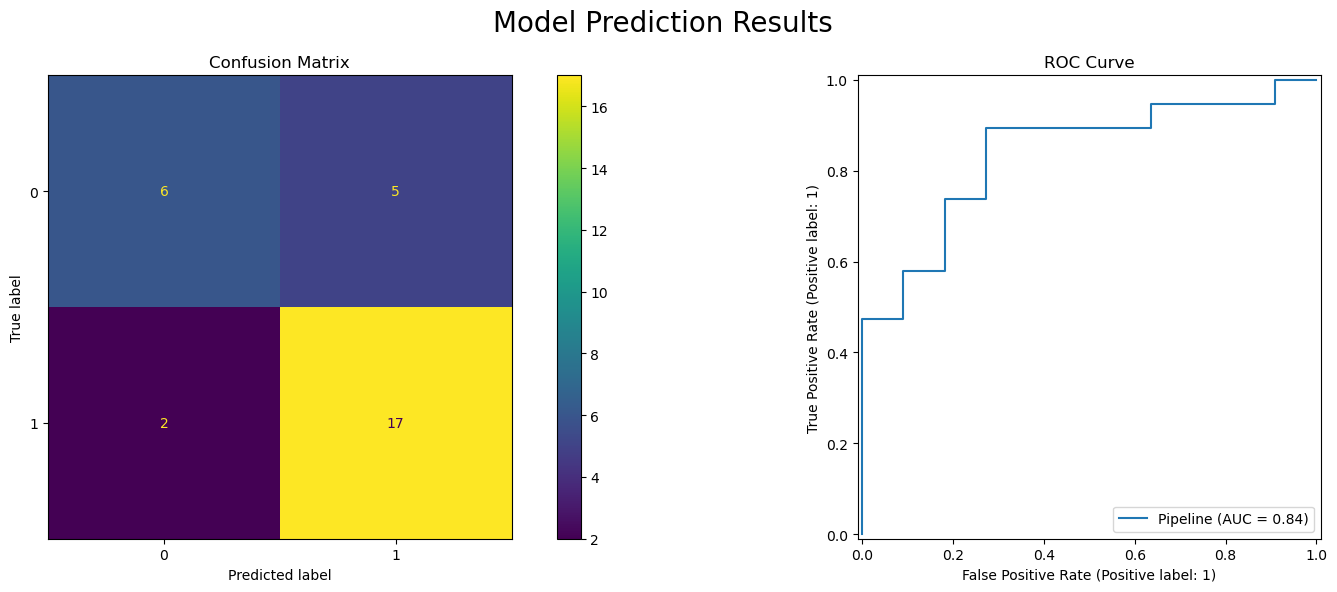

In [32]:
# Model Predictions & Evaluation
#
model_randforest = grid_search.best_estimator_

start_time = time.perf_counter()
y_pred = model_randforest.predict(X_test)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_randforest, X_test, y_test, y_pred)

# Feature Importance / Contribution
# feature_importance(model_randforest, features_prep_pipeline)
